# 13/05/2024: First Simulations 

Serves the purpose to understand the problem of fairness under distribution shifts closer and to observe what happens when different (fair) models get transferred to different environments

### 0. Import of all neccesary packages 

In [2]:
import numpy as np  
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import entropy, chi2_contingency, norm, ttest_1samp
import scipy.spatial.distance as distance
import statsmodels.stats.multitest as multitest
from folktables import ACSDataSource
import statsmodels.api as sm


In [7]:
#Create sample hiring data

def hiring_data(shift, n=1000,d=0.09):
    
    np.random.seed(36)
    
    U = np.random.normal(0, 1, n)
    X = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
    Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
    W = np.random.binomial(1,0.3*(np.abs(X-Z)) + 0.1,n)
    Y = np.random.binomial(1,(1/5)*(X+Z-2*X*Z)+(1/4)*W+0.02,n)
    sample_1 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})

    if shift == 1:
        U = np.random.normal(0, 1, n)
        X = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        W = np.random.binomial(1,0.3*(np.abs(X-Z)) + 0.1,n)
        Y = np.random.binomial(1,(1/5)*(X+Z-2*X*Z)+(1/4)*W + 0.02 + d,n)
        sample_2 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})
    
    else:       
        U = np.random.normal(0, 1, n)
        X = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        W = np.random.binomial(1,0.3*(np.abs(X-Z)) + 0.1,n)
        Y = np.random.binomial(1,(1/5)*(X+Z-2*X*Z)+(1/4)*W+0.02,n)

        sample_2 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})
    
    return sample_1, sample_2

sample_1, sample_2 = hiring_data(0)
_ , sample_3 = hiring_data(1)

In [4]:
#Compute conditionals of Y on X, Z, W
p_y_xwz_s1 = sample_1.groupby(['X','W','Z'])['Y'].mean().reset_index().values
p_y_xwz_s2 = sample_2.groupby(['X','W','Z'])['Y'].mean().reset_index().values
p_y_xwz_s3 = sample_3.groupby(['X','W','Z'])['Y'].mean().reset_index().values
#Create index array
index = ["P(Y=1|X=0,W=0,Z=0)", "P(Y=1|X=0,W=0,Z=1)", "P(Y=1|X=0,W=1,Z=0)", "P(Y=1|X=0,W=1,Z=1)", "P(Y=1|X=1,W=0,Z=0)", "P(Y=1|X=1,W=0,Z=1)", "P(Y=1|X=1,W=1,Z=0)", "P(Y=1|X=1,W=1,Z=1)"]
#Create dataframe storing conditionals
p_y_xwz = pd.DataFrame({'sample_1':p_y_xwz_s1[:,3], 'sample_2':p_y_xwz_s2[:,3], 'sample_3':p_y_xwz_s3[:,3]}, index = index)

#Compute differences between sample 1 and sample 2
diff_1_2 = p_y_xwz['sample_1'] - p_y_xwz['sample_2']
#Turn into dataframe
diff_1_2 = pd.DataFrame(diff_1_2, columns = ['diff_1_2'])
#compute kl divergence between sample 1 and sample 2
kl_1_2 = entropy(p_y_xwz['sample_1'], p_y_xwz['sample_2'])
#compute js divergence between sample 1 and sample 2
js_1_2 = distance.jensenshannon(p_y_xwz['sample_1'], p_y_xwz['sample_2'])
#Compute differences between sample 1 and sample 3
diff_1_3 = p_y_xwz['sample_1'] - p_y_xwz['sample_3']
#Turn into dataframe
diff_1_3 = pd.DataFrame(diff_1_3, columns = ['diff_1_3'])
#compute kl divergence between sample 1 and sample 3
kl_1_3 = entropy(p_y_xwz['sample_1'], p_y_xwz['sample_3'])
#compute js divergence between sample 1 and sample 3
js_1_3 = distance.jensenshannon(p_y_xwz['sample_1'], p_y_xwz['sample_3'])

print(f"Divergences between sample 1 and sample 2: KL = {np.round(kl_1_2,4)}, JS = {np.round(js_1_2,4)}")
print(f"Divergences between sample 1 and sample 3: KL = {np.round(kl_1_3,4)}, JS = {np.round(js_1_3,4)}")


Divergences between sample 1 and sample 2: KL = 0.0141, JS = 0.0601
Divergences between sample 1 and sample 3: KL = 0.0665, JS = 0.1412


In [17]:
def bootstrap_divergences(sample_a, sample_b, B=20000):
    # Compute conditionals of Y on X, Z, W
    p_y_xwz_s1 = sample_a.groupby(['X', 'W', 'Z'])['Y'].mean().reset_index()['Y'].values
    p_y_xwz_s2 = sample_b.groupby(['X', 'W', 'Z'])['Y'].mean().reset_index()['Y'].values

    # Compute observed divergences
    kl = entropy(p_y_xwz_s1, p_y_xwz_s2)
    js = distance.jensenshannon(p_y_xwz_s1, p_y_xwz_s2)

    # Create arrays to store bootstrap divergences
    kl_boot = np.zeros(B)
    js_boot = np.zeros(B)

    for i in tqdm.tqdm(range(B), desc='Bootstrapping'):
        # Pool samples
        #pooled = pd.concat([sample_a, sample_b])
        
        # Create bootstrap samples
        #bootstrap_sample_a = pooled.sample(len(sample_a), replace=True)
        #bootstrap_sample_b = pooled.sample(len(sample_b), replace=True)

        bootstrap_sample_a = sample_a.sample(len(sample_a), replace=True)
        bootstrap_sample_b = sample_b.sample(len(sample_b), replace=True)

        # Compute conditionals of Y on X, Z, W
        p_y_xwz_s1 = bootstrap_sample_a.groupby(['X', 'W', 'Z'])['Y'].mean().reset_index()['Y'].values
        p_y_xwz_s2 = bootstrap_sample_b.groupby(['X', 'W', 'Z'])['Y'].mean().reset_index()['Y'].values
        
        # Compute divergences
        kl_boot[i] = entropy(p_y_xwz_s1, p_y_xwz_s2) 
        js_boot[i] = distance.jensenshannon(p_y_xwz_s1, p_y_xwz_s2) 

    # Compute p-values: fraction of absolute bootstrap divergences that are greater or equal than the absolute observed divergence
    p_kl = np.mean(np.abs(kl_boot) >= np.abs(kl))
    p_js = np.mean(np.abs(js_boot) >= np.abs(js))
    
    #Compute a CI for the divergences
    lower_bound_kl = 2*kl-np.quantile(kl_boot,0.975)
    upper_bound_kl = 2*kl-np.quantile(kl_boot,0.025)
    lower_bound_js = 2*js-np.quantile(js_boot,0.975)
    upper_bound_js = 2*js-np.quantile(js_boot,0.025)
    
    ci_kl = [lower_bound_kl, upper_bound_kl]
    ci_js = [lower_bound_js, upper_bound_js]

    return kl, js, kl_boot, js_boot, p_kl, p_js, ci_kl, ci_js

kl_s1s2, js_s1s2, kl_boot_s1s2, js_boot_s1s2, p_kl_s1s2, p_js_s1s2,ci_kl_s1s2, ci_js_s1s2 = bootstrap_divergences(sample_1, sample_2)
kl_s1s3, js_s1s3, kl_boot_s1s3, js_boot_s1s3, p_kl_s1s3, p_js_s1s3, ci_kl_s1s3, ci_js_s1s3 = bootstrap_divergences(sample_1, sample_3)


Bootstrapping: 100%|██████████| 20000/20000 [01:25<00:00, 234.20it/s]
c:\Users\41782\miniconda3\envs\Thesis\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
Bootstrapping: 100%|██████████| 20000/20000 [01:25<00:00, 234.25it/s]


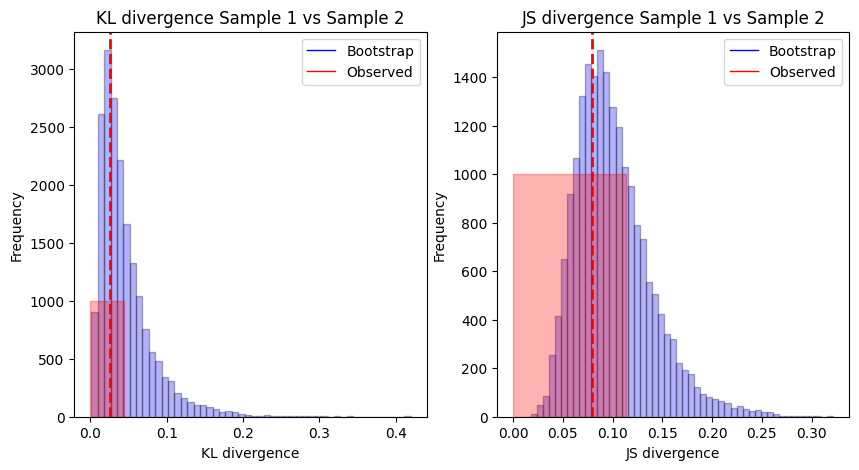

<Figure size 640x480 with 0 Axes>

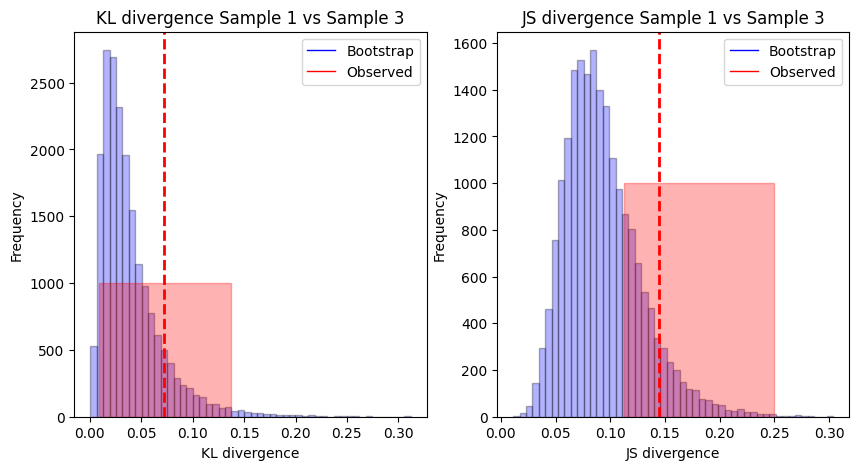

<Figure size 640x480 with 0 Axes>

In [16]:
#Histogram of bootstrap divergences
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#need to remove inf values in kl_boot_s1s2
kl_boot_s1s2 = kl_boot_s1s2[~np.isinf(kl_boot_s1s2)]
axs[0].hist(kl_boot_s1s2, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0].axvline(kl_s1s2, color='red', linestyle='dashed', linewidth=2)
axs[0].set_title('KL divergence Sample 1 vs Sample 2')
axs[0].set_xlabel('KL divergence')
axs[0].set_ylabel('Frequency')
#add the CI as shaded area
axs[0].fill_betweenx([0, 1000], 0, ci_kl_s1s2[1], color='red', alpha=0.3)
#add pvalue 
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[0].legend(handles=handles) # + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_kl_s1s2}')])

axs[1].hist(js_boot_s1s2, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1].axvline(js_s1s2, color='red', linestyle='dashed', linewidth=2)
axs[1].set_title('JS divergence Sample 1 vs Sample 2')
axs[1].set_xlabel('JS divergence')
axs[1].set_ylabel('Frequency')
#add the CI as shaded area
axs[1].fill_betweenx([0, 1000], 0 if ci_js_s1s2[0] < 0 else  ci_js_s1s2[0], ci_js_s1s2[1], color='red', alpha=0.3)
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[1].legend(handles=handles)# + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_js_s1s2}')])
plt.show()
plt.tight_layout()

#Histogram of bootstrap divergences
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#need to remove inf values in kl_boot_s1s3
kl_boot_s1s3 = kl_boot_s1s3[~np.isinf(kl_boot_s1s3)]
axs[0].hist(kl_boot_s1s3, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0].axvline(kl_s1s3, color='red', linestyle='dashed', linewidth=2)
axs[0].set_title('KL divergence Sample 1 vs Sample 3')
axs[0].set_xlabel('KL divergence')
axs[0].set_ylabel('Frequency')
#add the CI as shaded area
axs[0].fill_betweenx([0, 1000],ci_kl_s1s3[0] , ci_kl_s1s3[1], color='red', alpha=0.3)
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[0].legend(handles=handles)# + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_kl_s1s3}')])

axs[1].hist(js_boot_s1s3, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1].axvline(js_s1s3, color='red', linestyle='dashed', linewidth=2)
axs[1].set_title('JS divergence Sample 1 vs Sample 3')
axs[1].set_xlabel('JS divergence')
axs[1].set_ylabel('Frequency')
axs[1].fill_betweenx([0, 1000],ci_js_s1s3[0], ci_js_s1s3[1], color='red', alpha=0.3)
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[1].legend(handles=handles)# + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_js_s1s3}')])
plt.show()
plt.tight_layout()



In [2]:
import numpy as np
import pandas as pd 
import graphviz as gr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV #, LogisticRegression
from sklearn.metrics import  accuracy_score
#from xgboost import XGBClassifier, DMatrix
#from typing import Tuple
!pip install fairlearn
from fairlearn.reductions import ExponentiatedGradient, DemographicParity #,  ErrorRate, GridSearch    

#from scipy.stats import bernoulli
random_seed = 10


## 1. Create a dataset/ import a real world dataset

We will adopt the Berkely Admissions Example.

1.1 We at first create a function which lets us generate different versions of the Berkeley Admissions example and its corresponding DAG 

In [179]:
#Function generating different versions of the scenario 
def berkeley_admissions_data(n, Ux, Ud, effect_x_d, Uy, effect_x_y, effect_d_y,effect_z_d, effect_z_y):
    #Generate variables with respect to causal hierachy
    #X -> Gender (0,1), 0 if applicant female, 1 if applicant male 
    p_x = Ux
    X = np.random.binomial(1, p_x, n)
    #Z -> Household income in thousands ~ N(75, 30)
    mu_Z = 150*Ux
    sigma_Z = 60*Ux
    Z = np.random.normal(mu_Z, sigma_Z, n)
    #D -> Department (0,1), 0 if applicant applies to department A, 1 if applicant applies to department B
    p_d = Ud + effect_x_d*X +effect_z_d*(Z - np.min(Z))/(np.max(Z) - np.min(Z))
    D = np.random.binomial(1, p_d, n)
    #Y -> Admission (0,1), 0 if applicant rejected, 1 if applicant admitted
    p_y = Uy + effect_x_y*X + effect_d_y*D + effect_z_y*(Z - np.min(Z))/(np.max(Z) - np.min(Z))
    Y = np.random.binomial(1, p_y, n)   

    #Return the data as a pandas dataframe
    berkeley_admissions_data_df = pd.DataFrame({'X': X,'Z':Z , 'D': D, 'Y': Y})

    #also return the assumed causal graph associated with the data
    DAG = gr.Digraph()
    #X will always be our source node
    DAG.node('X')
    #Add node D
    DAG.node('D')
    #Add node Y
    DAG.node('Y')
    #If the effect of X on D is non-zero, add an edge from X to D
    if effect_x_d != 0:
        DAG.edge('X', 'D')
    #If the effect of X on Y is non-zero, add an edge from X to Y
    if effect_x_y != 0:
        DAG.edge('X', 'Y')
    #If the effect of D on Y is non-zero, add an edge from D to Y
    if effect_d_y != 0:
        DAG.edge('D', 'Y')
    #If the effect of Z on D is non-zero, add an edge from Z to D
    if effect_z_d != 0:
        DAG.edge('Z', 'D')
    #If the effect of Z on Y is non-zero, add an edge from Z to Y
    if effect_z_y != 0:
        DAG.edge('Z', 'Y')
    #Bi-directed edge between X and Z
    DAG.edge('X', 'Z', style='dashed', dir='both')

    return berkeley_admissions_data_df, DAG


    


1.2 Now, we generate some data 

In [180]:
np.random.seed(random_seed)
n=1000
#Generate some data according to a modified version of  example 3.1, where there is a no direct effect from X to Y
scm_no_de, dag_no_de = berkeley_admissions_data(n,0.5,0.25,0.4,0.1,0,0.3,0.2,0.5)
#Generate some data according to a modified version of  example 3.1, where there is a direct effect from X to Y
scm_de, dag_de = berkeley_admissions_data(n,0.5,0.25,0.25,0.1,0.3,0.3,0.2,0.3)



1.3 We briefly explore the data and have a look at their DAGs 

SCM with no direct effect from X to Y
Gender distribution:  X
0    0.503
1    0.497
Name: proportion, dtype: float64
         D     Z     Y
X=0  73.25  0.36  0.48
X=1  75.60  0.77  0.61
Conditional probability of Y = 1 given X = 1: 0.6137
Conditional probability of Y = 1 given X = 0: 0.4811
Total Variation: 0.1326
DAG with no direct effect from X to Y


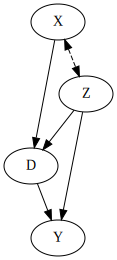


 SCM with direct effect from X to Y
Gender distribution:  X
0    0.503
1    0.497
Name: proportion, dtype: float64
         D     Z     Y
X=0  73.95  0.34  0.37
X=1  73.27  0.63  0.77
Conditional probability of Y = 1 given X = 1: 0.7732
Conditional probability of Y = 1 given X = 0: 0.3706
Total Variation: 0.4026
DAG with direct effect from X to Y


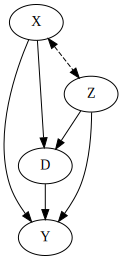

In [181]:
#Explore the data
############################SCM with no direct effect from X to Y###############################################
print('SCM with no direct effect from X to Y')
#print gender distribution
print("Gender distribution: ", scm_no_de['X'].value_counts(normalize=True))
# group by X=0 and X=1 and then compute mean D, Z and Y
#indices where X = 0
indices_x0 = scm_no_de[scm_no_de['X'] == 0].index
#indices where X = 1
indices_x1 = scm_no_de[scm_no_de['X'] == 1].index
#mean of D, Z and Y when X = 0
mean_x0 = np.round(scm_no_de.loc[indices_x0].mean().drop('X'),2) 
#mean of D, Z and Y when X = 1
mean_x1 = np.round(scm_no_de.loc[indices_x1].mean().drop('X'),2)
#display in a table, where X = 0 and X = 1 are the rows and D, Z and Y are the columns
print(pd.DataFrame(np.matrix([mean_x0, mean_x1]), columns=['D', 'Z', 'Y'], index=['X=0', 'X=1']))
##Find conditional probability of Y = 1 given X = 1
p_y_given_x1 = ((scm_no_de[scm_no_de['X'] == 1]['Y'] == 1).sum()) / len(scm_no_de[scm_no_de['X'] == 1]) 
#find conditional probability of Y = 1 given X = 0
p_y_given_x0 = ((scm_no_de[scm_no_de['X'] == 0]['Y'] == 1).sum()) / len(scm_no_de[scm_no_de['X'] == 0])
## find their difference
print('Conditional probability of Y = 1 given X = 1:', np.round(p_y_given_x1, 4))
print('Conditional probability of Y = 1 given X = 0:', np.round(p_y_given_x0, 4))
tv = p_y_given_x1 - p_y_given_x0
print('Total Variation:', np.round(tv, 4))
print('DAG with no direct effect from X to Y')
display(dag_no_de) #printing the DAG
############################SCM with direct effect from X to Y###############################################
print('\n SCM with direct effect from X to Y')
#print gender distribution
print("Gender distribution: ", scm_no_de['X'].value_counts(normalize=True))
# group by X=0 and X=1 and then compute mean D, Z and Y
#indices where X = 0
indices_x0 = scm_de[scm_de['X'] == 0].index
#indices where X = 1
indices_x1 = scm_de[scm_de['X'] == 1].index
#mean of D, Z and Y when X = 0
mean_x0 = np.round(scm_de.loc[indices_x0].mean().drop('X'),2) 
#mean of D, Z and Y when X = 1
mean_x1 = np.round(scm_de.loc[indices_x1].mean().drop('X'),2)
#display in a table, where X = 0 and X = 1 are the rows and D, Z and Y are the columns
print(pd.DataFrame(np.matrix([mean_x0, mean_x1]), columns=['D', 'Z', 'Y'], index=['X=0', 'X=1']))
##Find conditional probability of Y = 1 given X = 1
p_y_given_x1 = ((scm_de[scm_de['X'] == 1]['Y'] == 1).sum()) / len(scm_de[scm_de['X'] == 1]) 
#find conditional probability of Y = 1 given X = 0
p_y_given_x0 = ((scm_de[scm_de['X'] == 0]['Y'] == 1).sum()) / len(scm_de[scm_de['X'] == 0])
## find their difference
print('Conditional probability of Y = 1 given X = 1:', np.round(p_y_given_x1, 4))
print('Conditional probability of Y = 1 given X = 0:', np.round(p_y_given_x0, 4))
tv = p_y_given_x1 - p_y_given_x0
print('Total Variation:', np.round(tv, 4))
print('DAG with direct effect from X to Y')
display(dag_de) #printing the DAG




2. Now we are going to train two predictors on data. 
First, simple logistic regression without any constraints
Second, logistic regression with reduction approach inspired by Agarwal et al. 2018 and implemented using the fairlearn package. 

2.1 First, we split our data into training and test set.

In [189]:
#Split the data into training and test sets
features = ['D', 'Z']
sensitive_attribute = ['X']
features_no_de = scm_no_de[features]
sensitive_attribute_no_de = scm_no_de[sensitive_attribute]
#Create dummy variables for Variable D as it is binary
features_no_de = pd.get_dummies(features_no_de, columns = ['D'], drop_first=False)
target_no_de = scm_no_de['Y']

features_de = scm_de[features]
sensitive_attribute_de = scm_de[sensitive_attribute]
#Create dummy variables for the features as they are all binary
features_de = pd.get_dummies(features_de,  columns = ['D'], drop_first=False)
target_de = scm_de['Y']
#Create training and test sets
X_train_no_de, X_test_no_de, y_train_no_de, y_test_no_de, A_train_no_de,A_test_no_de  = train_test_split(features_no_de, target_no_de,sensitive_attribute_no_de, test_size=0.25, random_state=random_seed)
X_train_de, X_test_de, y_train_de, y_test_de, A_train_de,A_test_de = train_test_split(features_de, target_de,sensitive_attribute_de, test_size=0.25, random_state=random_seed)


2.2 Now we will fit our baseline classifier - logistic regression without any constraints

In [183]:
np.random.seed(random_seed)
#Now we will fit a logistic regression model to the data for both SCMs
#Fit a logistic regression model to the data

logistic_model_no_de = LogisticRegressionCV(cv=5, random_state=random_seed)
logistic_model_no_de.fit(X_train_no_de, y_train_no_de)
logistic_model_de = LogisticRegressionCV(cv=5, random_state=random_seed)
logistic_model_de.fit(X_train_de, y_train_de)

#Make predictions
y_pred_no_de = logistic_model_no_de.predict(X_test_no_de)
y_pred_de = logistic_model_de.predict(X_test_de)

#Evaluate the model
print('No direct effect from X to Y')
print('Accuracy:', accuracy_score(y_test_no_de, y_pred_no_de))
#compute total variation (TV) between the predicted and actual values of Y conditional on X
#Compute P(Y=1|X=1)
p_y_given_x1 = y_pred_no_de[A_test_no_de['X'] == 1].mean()
#Compute P(Y=1|X=0)
p_y_given_x0 = y_pred_no_de[A_test_no_de['X'] == 0].mean()
#Compute TV
tv = np.abs(p_y_given_x1 - p_y_given_x0)
print('Total Variation:', np.round(tv,4))
print('Direct effect from X to Y')
print('Accuracy:', accuracy_score(y_test_de, y_pred_de))
#compute total variation (TV) between the predicted and actual values of Y conditional on X
#Compute P(Y=1|X=1)
p_y_given_x1 = y_pred_de[A_test_de['X'] == 1].mean()
#Compute P(Y=1|X=0)
p_y_given_x0 = y_pred_de[A_test_de['X'] == 0].mean()
#Compute TV
tv = np.abs(p_y_given_x1 - p_y_given_x0)
print('Total Variation:', np.round(tv,4))


No direct effect from X to Y
Accuracy: 0.652
Total Variation: 0.308
Direct effect from X to Y
Accuracy: 0.716
Total Variation: 0.2501


We can see that in the case where there is a direct effect from X to Y, we see higher accuracy. Also, we see a higher TV measure for the case where there is no direct effect from X to Y.


2.3 Now, we will fit a "fair" model, which is a reductions approach as in Agarwal et al. 2018

In [190]:
#Now we will fit a "fair" model using Fairlearn to the data for both SCMs for the same base classifier
np.random.seed(random_seed)

fair_logistic_model_no_de = ExponentiatedGradient(logistic_model_no_de,
                   constraints=DemographicParity(difference_bound=0))
fair_logistic_model_no_de.fit(X_train_no_de, y_train_no_de, sensitive_features=A_train_no_de)

fair_logistic_model_de = ExponentiatedGradient(logistic_model_de,
                   constraints=DemographicParity(difference_bound=0))
fair_logistic_model_de.fit(X_train_de, y_train_de, sensitive_features=A_train_de)   

#Make predictions
y_pred_fair_no_de = fair_logistic_model_no_de.predict(X_test_no_de)
y_pred_fair_de = fair_logistic_model_de.predict(X_test_de)


c:\Users\41782\miniconda3\envs\Thesis\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
c:\Users\41782\miniconda3\envs\Thesis\lib\site-packag

In [191]:
#Evaluate the model
print('No direct effect from X to Y - Fair Model')
print('Accuracy:', accuracy_score(y_test_no_de, y_pred_fair_no_de))
#compute total variation (TV) between the predicted and actual values of Y conditional on X
#Compute P(Y=1|X=1)
p_y_given_x1 = y_pred_fair_no_de[A_test_no_de['X'] == 1].mean()
#Compute P(Y=1|X=0)
p_y_given_x0 = y_pred_fair_no_de[A_test_no_de['X'] == 0].mean()
#Compute TV
tv = np.abs(p_y_given_x1 - p_y_given_x0)
print('Total Variation:', np.round(tv,4))
print('Direct effect from X to Y - Fair Model')
print('Accuracy:', accuracy_score(y_test_de, y_pred_fair_de))
#compute total variation (TV) between the predicted and actual values of Y conditional on X
#Compute P(Y=1|X=1)
p_y_given_x1 = y_pred_fair_de[A_test_de['X'] == 1].mean()
#Compute P(Y=1|X=0)
p_y_given_x0 = y_pred_fair_de[A_test_de['X'] == 0].mean()
#Compute TV
tv = np.abs(p_y_given_x1 - p_y_given_x0)
print('Total Variation:', np.round(tv,4))

No direct effect from X to Y - Fair Model
Accuracy: 0.572
Total Variation: 0.1201
Direct effect from X to Y - Fair Model
Accuracy: 0.524
Total Variation: 0.0632


In comparison to the unconstrained case, we definetly see some drop in accuracy. However, the total variation is significantly reduced. A bit surprising is that the Total Variation is still not near zero for both cases. I followed the documentation of the fairlearn package quite closely, nonetheless, I will need to have another look to check the result.

3. Distribution Shift

3.1 Generate shifted data. We will now generate new data where there is a shift in D. The shift affects the exogenous variable, and the magnitude of effects from Z and X on D. We could think of this shifted data, as admissions data from another University, for instance, the University of Alaska. 

In [199]:
np.random.seed(random_seed)
#we will generate two new datasets where the generating distribution is shifted. We make the shift more extreme on purpose to make the neccesity of causal constraints more apparent
shift_scm_no_de = berkeley_admissions_data(n,0.5,0.01,0.9,0.1,0,0.3,0.09,0.5)[0] #shift in D (exogenous factor + effect of X on D  + effect of Z on D)
shift_scm_de = berkeley_admissions_data(n,0.5,0.01,0.95,0.1,0.3,0.3,0.01,0.3)[0] #shift in D (exogenous factor + effect of X on D +effect of Z on D)


#similar to before: exlore data
############################SCM with no direct effect from X to Y###############################################
print('Shifted SCM with no direct effect from X to Y')
#print gender distribution
print("Gender distribution: ", shift_scm_no_de['X'].value_counts(normalize=True))
# group by X=0 and X=1 and then compute mean D, Z and Y
#indices where X = 0
indices_x0 = shift_scm_no_de[shift_scm_no_de['X'] == 0].index
#indices where X = 1
indices_x1 = shift_scm_no_de[shift_scm_no_de['X'] == 1].index
#mean of D, Z and Y when X = 0
mean_x0 = np.round(shift_scm_no_de.loc[indices_x0].mean().drop('X'),2) 
#mean of D, Z and Y when X = 1
mean_x1 = np.round(shift_scm_no_de.loc[indices_x1].mean().drop('X'),2)
#display in a table, where X = 0 and X = 1 are the rows and D, Z and Y are the columns
print(pd.DataFrame(np.matrix([mean_x0, mean_x1]), columns=['D', 'Z', 'Y'], index=['X=0', 'X=1']))
##Find conditional probability of Y = 1 given X = 1
p_y_given_x1 = ((shift_scm_no_de[shift_scm_no_de['X'] == 1]['Y'] == 1).sum()) / len(shift_scm_no_de[shift_scm_no_de['X'] == 1]) 
#find conditional probability of Y = 1 given X = 0
p_y_given_x0 = ((shift_scm_no_de[shift_scm_no_de['X'] == 0]['Y'] == 1).sum()) / len(shift_scm_no_de[shift_scm_no_de['X'] == 0])
## find their difference
print('Conditional probability of Y = 1 given X = 1:', np.round(p_y_given_x1, 4))
print('Conditional probability of Y = 1 given X = 0:', np.round(p_y_given_x0, 4))
tv = p_y_given_x1 - p_y_given_x0
print('Total Variation:', np.round(tv, 4))
############################SCM with direct effect from X to Y###############################################
print('\n Shifted SCM with direct effect from X to Y')
#print gender distribution
print("Gender distribution: ", shift_scm_de['X'].value_counts(normalize=True))
# group by X=0 and X=1 and then compute mean D, Z and Y
#indices where X = 0
indices_x0 = shift_scm_de[shift_scm_de['X'] == 0].index
#indices where X = 1
indices_x1 = shift_scm_de[shift_scm_de['X'] == 1].index
#mean of D, Z and Y when X = 0
mean_x0 = np.round(shift_scm_de.loc[indices_x0].mean().drop('X'),2) 
#mean of D, Z and Y when X = 1
mean_x1 = np.round(shift_scm_de.loc[indices_x1].mean().drop('X'),2)
#display in a table, where X = 0 and X = 1 are the rows and D, Z and Y are the columns
print(pd.DataFrame(np.matrix([mean_x0, mean_x1]), columns=['D', 'Z', 'Y'], index=['X=0', 'X=1']))
##Find conditional probability of Y = 1 given X = 1
p_y_given_x1 = ((shift_scm_de[shift_scm_de['X'] == 1]['Y'] == 1).sum()) / len(shift_scm_de[shift_scm_de['X'] == 1]) 
#find conditional probability of Y = 1 given X = 0
p_y_given_x0 = ((shift_scm_de[shift_scm_de['X'] == 0]['Y'] == 1).sum()) / len(shift_scm_de[shift_scm_de['X'] == 0])
## find their difference
print('Conditional probability of Y = 1 given X = 1:', np.round(p_y_given_x1, 4))
print('Conditional probability of Y = 1 given X = 0:', np.round(p_y_given_x0, 4))
tv = p_y_given_x1 - p_y_given_x0
print('Total Variation:', np.round(tv, 4))
print('DAG with direct effect from X to Y')





Shifted SCM with no direct effect from X to Y
Gender distribution:  X
0    0.503
1    0.497
Name: proportion, dtype: float64
         D     Z     Y
X=0  73.25  0.06  0.36
X=1  75.60  0.96  0.69
Conditional probability of Y = 1 given X = 1: 0.6861
Conditional probability of Y = 1 given X = 0: 0.3638
Total Variation: 0.3223

 Shifted SCM with direct effect from X to Y
Gender distribution:  X
0    0.537
1    0.463
Name: proportion, dtype: float64
         D     Z     Y
X=0  73.95  0.01  0.27
X=1  73.27  0.98  0.87
Conditional probability of Y = 1 given X = 1: 0.8661
Conditional probability of Y = 1 given X = 0: 0.2737
Total Variation: 0.5923
DAG with direct effect from X to Y


3.2 Different to before, we will deploy the previously trained models on the new domain (i.e. we will apply them to the full dataset to emulate deployed productized algorithms in real-life)

In [200]:
#Split the data into training,test sets and also save the sensitive attribute
features = ['D','Z']
sensitive_attribute = ['X']
features_no_de = shift_scm_no_de[features]
sensitive_attribute_no_de = shift_scm_no_de[sensitive_attribute]
#Create dummy variables for the features as they are all binary
features_no_de = pd.get_dummies(features_no_de, columns = ['D'], drop_first=False)
target_no_de = shift_scm_no_de['Y']
#We will predictions now on the whole dataset
X_shift_no_de = features_no_de

features_de = shift_scm_de[features]
sensitive_attribute_de = shift_scm_de[sensitive_attribute]
#Create dummy variables for the features as they are all binary
features_de = pd.get_dummies(features_de, columns = ['D'], drop_first=False)
target_de = shift_scm_de['Y']
#We will predictions now on the whole dataset
X_shift_de = features_de



In [201]:
np.random.seed(random_seed)
#Make predictions using the previously trained models
y_pred_shift_no_de = logistic_model_no_de.predict(X_shift_no_de)
y_pred_shift_de = logistic_model_de.predict(X_shift_de)
y_pred_fair_shift_no_de = fair_logistic_model_no_de.predict(X_shift_no_de)
y_pred_fair_shift_de = fair_logistic_model_de.predict(X_shift_de)

#Evaluate the models
print('No direct effect from X to Y')
print('Accuracy:', accuracy_score(target_no_de, y_pred_shift_no_de))
#compute total variation (TV) between the predicted and actual values of Y conditional on X
#Compute P(Y=1|X=1)
p_y_given_x1 = y_pred_shift_no_de[sensitive_attribute_no_de['X'] == 1].mean()
#Compute P(Y=1|X=0)
p_y_given_x0 = y_pred_shift_no_de[sensitive_attribute_no_de['X'] == 0].mean()
#Compute TV
tv = np.abs(p_y_given_x1 - p_y_given_x0)
print('Total Variation:', np.round(tv,4))
print('Direct effect from X to Y')
print('Accuracy:', accuracy_score(target_de, y_pred_shift_de))
#compute total variation (TV) between the predicted and actual values of Y conditional on X
#Compute P(Y=1|X=1)
p_y_given_x1 = y_pred_shift_de[sensitive_attribute_de['X'] == 1].mean()
#Compute P(Y=1|X=0)
p_y_given_x0 = y_pred_shift_de[sensitive_attribute_de['X'] == 0].mean()
#Compute TV
tv = np.abs(p_y_given_x1 - p_y_given_x0)
print('Total Variation:', np.round(tv,4))
print('No direct effect from X to Y - fair model')
print('Accuracy:', accuracy_score(target_no_de, y_pred_fair_shift_no_de))
#compute total variation (TV) between the predicted and actual values of Y conditional on X
#Compute P(Y=1|X=1)
p_y_given_x1 = y_pred_fair_shift_no_de[sensitive_attribute_no_de['X'] == 1].mean()
#Compute P(Y=1|X=0)
p_y_given_x0 = y_pred_fair_shift_no_de[sensitive_attribute_no_de['X'] == 0].mean()
#Compute TV
tv = np.abs(p_y_given_x1 - p_y_given_x0)
print('Total Variation:', np.round(tv,4))
print('Direct effect from X to Y - fair model')
print('Accuracy:', accuracy_score(target_de, y_pred_fair_shift_de))
#compute total variation (TV) between the predicted and actual values of Y conditional on X
#Compute P(Y=1|X=1)
p_y_given_x1 = y_pred_fair_shift_de[sensitive_attribute_de['X'] == 1].mean()
#Compute P(Y=1|X=0)
p_y_given_x0 = y_pred_fair_shift_de[sensitive_attribute_de['X'] == 0].mean()
#Compute TV
tv = np.abs(p_y_given_x1 - p_y_given_x0)
print('Total Variation:', np.round(tv,4))


No direct effect from X to Y
Accuracy: 0.669
Total Variation: 0.6968
Direct effect from X to Y
Accuracy: 0.796
Total Variation: 0.9694
No direct effect from X to Y - fair model
Accuracy: 0.535
Total Variation: 0.29
Direct effect from X to Y - fair model
Accuracy: 0.544
Total Variation: 0.0244


In this case, we made the environment such that D depends very strongly on X (indirect effect is increased). The two baseline classifiers while being more accurate than on the training domain they extremely worsened when considering the Total Variation for the predicted Y's. 

For the two "fair" models we also see quite interesting results. While the accuracy stays somewhat in the same ballpark as in the training environment, we see that opposite results for the Total Variation. In the case of no direct effect, the Total Variation increases strongly, while in the case with a direct effect, the Total Variation shrinks quite strongly. 

The caveat is that this is a very artificial scenario and possibly not very realistic in practive. However, what it still hints at is that simply minimizing a (not decomposed) metric such as the Total Variation/Demographic Parity will give us no guarantee with respect to its behaviour under distribution shifts. This makes them somewhat unpredictable and a potential danger in safety-critical applications. Thus, it incentivizes to search for alternatives, for instance, finer-grained causal constraints.